In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
boxLen = 1000.

In [2]:
Nparticles = 30000
random_data = boxLen*np.random.random((Nparticles,3))
# np.savetxt('/home/icgguest/Desktop/DATA/random_data_test', random_data, fmt='%0.6f')

Particle-Mesh Algorithm for the Power Spectrum 
NGP and CIC methods for random data, galaxy data, dark matter data

In [4]:
data = boxLen*np.random.random((Nparticles,3))
# data = np.loadtxt('/home/icgguest/Desktop/DATA/MDR1_Main1_gals.txt')
# data = data[:,1:4]
# Nparticles = len(data)
#np.savetxt('/home/icgguest/Desktop/DATA/Main1_gals.txt', data, fmt='%0.6f', header = '%d'%len(data))
Ngrid = 128
a = boxLen/Ngrid
coord = np.array(np.floor(data/a),dtype=int)
centre = coord*a + a/2
rhoCIC = np.zeros((Ngrid, Ngrid, Ngrid))
rhoNGP = np.zeros((Ngrid, Ngrid, Ngrid))
Particles = range(0, Nparticles)
for ic in Particles:
    d=(data[ic]-centre[ic])/a
    t=1- np.abs(d)
    s = np.array(np.sign(d), dtype = int)
    d = np.abs(d)
    rhoNGP[coord[ic,0],coord[ic,1],coord[ic,2]] += 1
    rhoCIC[coord[ic,0],coord[ic,1],coord[ic,2]]+= t[0]*t[1]*t[2]
    rhoCIC[(coord[ic,0]+s[0])%Ngrid,coord[ic,1],coord[ic,2]]+= d[0]*t[1]*t[2]
    rhoCIC[coord[ic,0],(coord[ic,1]+s[1])%Ngrid,coord[ic,2]]+= t[0]*d[1]*t[2]
    rhoCIC[coord[ic,0],coord[ic,1],(coord[ic,2]+s[2])%Ngrid]+= t[0]*t[1]*d[2]
    rhoCIC[(coord[ic,0]+s[0])%Ngrid,coord[ic,1],(coord[ic,2]+s[2])%Ngrid]+= d[0]*t[1]*d[2]
    rhoCIC[coord[ic,0],(coord[ic,1]+s[1])%Ngrid,(coord[ic,2]+s[2])%Ngrid]+= t[0]*d[1]*d[2]
    rhoCIC[(coord[ic,0]+s[0])%Ngrid,(coord[ic,1]+s[1])%Ngrid,(coord[ic,2]+s[2])%Ngrid]+= d[0]*d[1]*d[2]

In [ ]:
delta = np.load('/home/icgguest/Desktop/DATA/MDR1_Delta_256.npy')

In [5]:
Ngrid = 128   #change here
a = boxLen/Ngrid
v = a**3
V = boxLen**3
rhoCIC = rhoCIC/v
rhomean = Nparticles/V
deltaCIC = (rhoCIC/rhomean)-1
rhoNGP = rhoNGP/v
deltaNGP = (rhoNGP/rhomean)-1
deltakNGP = np.fft.fftn(deltaNGP)
deltakCIC = np.fft.fftn(deltaCIC)  #change here for delta

In [6]:
fac = 1/(Ngrid*Ngrid*Ngrid)
fac = fac*fac
i = np.arange(0, Ngrid)
ii = np.arange(0, Ngrid)
ii[i>=Ngrid/2]-=Ngrid
Pofk = np.zeros(Ngrid)
nmodes = np.zeros(Ngrid)
Nover2 = int(Ngrid/2)
output = np.zeros((Nover2,2))
for ic in range(Ngrid**3):
    zind = int(ic%Ngrid)
    yind = int((ic/Ngrid)%Ngrid)
    xind = int(ic/(Ngrid**2))
    kind = int(np.sqrt(ii[xind]**2 + ii[yind]**2 + ii[zind]**2)+0.5)
    nmodes[kind] += 1.0 
    Pofk[kind] += (deltakCIC[xind,yind,zind].real)**2 + (deltakCIC[xind,yind,zind].imag)**2
Pofk = Pofk*fac   
for kind in range(Ngrid):
    if nmodes[kind] > 0:
        Pofk[kind] = Pofk[kind]/ nmodes[kind]
Pofk = Pofk - 1.0/Nparticles
for i in range(1, Nover2+1):
    output[i-1,0] = i
    output[i-1,1] = Pofk[i]
#np.savetxt('/home/icgguest/Desktop/Pofk_Delta_256', output,fmt='%d %0.6e')
#np.savetxt('/home/icgguest/Desktop/Pofk_Main1_gals', output,fmt='%d %0.6e')

Power Spectrum from the C++ code 'SimplePofk' and comparison galaxy/dark matter data

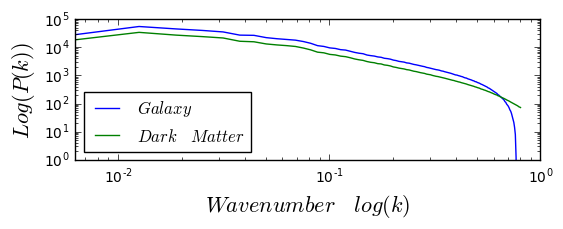

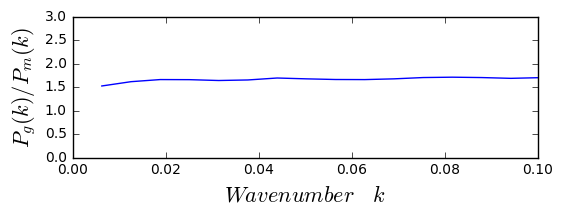

In [7]:
CPP = np.loadtxt('/home/icgguest/Desktop/SimplePofk/Pofk_Main1_gals_256')
Python = np.loadtxt('/home/icgguest/Desktop/SimplePofk/Pofk_DM_Dense_256')
plt.subplot(211)
plt.plot(CPP[:,0]*(2*np.pi/boxLen), CPP[:,1]*(boxLen**3), label = r'$Galaxy $')
plt.plot(Python[:,0]*(2*np.pi/boxLen), Python[:,1]*(boxLen**3), label = r'$Dark \quad Matter$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(np.amin(CPP[:,0]*(2*np.pi/boxLen)))
plt.xlabel(r'$Wavenumber \quad log(k)$', size ='16')
plt.ylabel(r'$Log(P(k))$', size ='16')
plt.legend(loc = 0)
plt.show()
plt.subplot(212)
plt.plot(CPP[:,0]*(2*np.pi/boxLen),CPP[:,1]/Python[:len(CPP),1])  
plt.xlim(0, 0.1)
plt.ylim(0, 3)
plt.xlabel(r'$Wavenumber \quad k$', size ='16')
plt.ylabel(r'$P_{g}(k)/P_{m}(k)$', size ='16')
plt.show()


Bias calculation from Pofk of galaxy and dark matter data

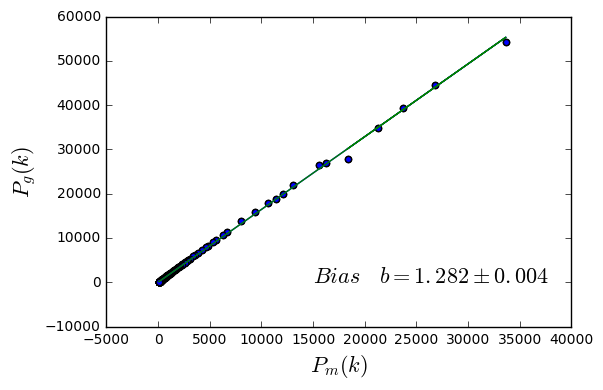

In [9]:
def linear(x, m):
    return m*x
popt, pcov = curve_fit(linear, Python[:len(CPP),1]*(boxLen**3), CPP[:,1]*(boxLen**3))
plt.plot(Python[:len(CPP),1]*(boxLen**3), linear(Python[:len(CPP),1]*(boxLen**3), popt))
plt.scatter(Python[:len(CPP),1]*(boxLen**3),CPP[:,1]*(boxLen**3))
bias = np.sqrt(popt)
berr = np.sqrt(np.diag(pcov))
plt.xlabel('$P_{m}(k)$', size ='16')
plt.ylabel('$P_{g}(k)$', size ='16')
plt.annotate(r'$Bias \quad b = %0.3f \pm %0.3f$' %(bias, berr) ,xy = (15000,0), size ='16')
plt.show()

Correlation function as a function of r and mu

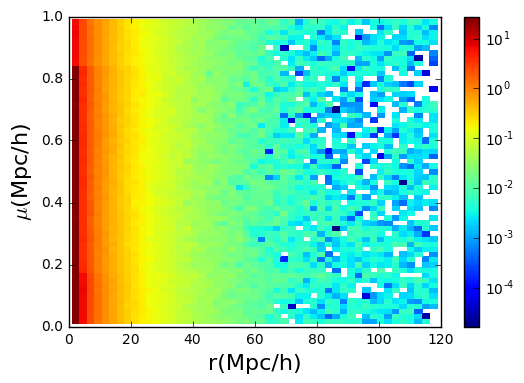

In [36]:
cf_rmu = np.loadtxt('/home/icgguest/Desktop/CUTE-1.3/CUTE_box/test/CFrmu_Mockgals.txt')
xi_rmu = cf_rmu[:,2].reshape(50,60)
x_rmu = cf_rmu[::60,0]
y_rmu = cf_rmu[:60,1]
plt.pcolormesh(x_rmu, y_rmu, xi_rmu.transpose(), norm= LogNorm())
plt.colorbar()
plt.xlabel('r(Mpc/h)',  size ='16')
plt.ylabel(r'$\mu$(Mpc/h)',  size ='16')
plt.show()

Correlation function for Mock galaxies data

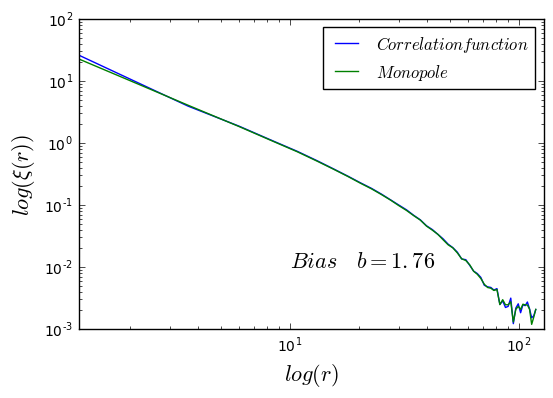

In [28]:
cf_mock = np.loadtxt('/home/icgguest/Desktop/CUTE-1.3/CUTE_box/test/CF_Mockgals.txt')
cf_mock = cf_mock[:,0:2]
plt.plot(cf_mock[:,0], cf_mock[:,1], label = r'$Correlation function$')
plt.plot(x_rmu ,monopole, label = r'$Monopole$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(np.amin(cf_mock[:,0]), np.amax(cf_mock[:,0])+10)
plt.xlabel('$log(r)$', size ='16')
plt.ylabel(r'$log(\xi(r))$', size ='16')
plt.legend(loc=0)
plt.annotate(r'$Bias \quad b = 1.76$',xy = (10,10**-2), size ='16')
plt.show()

Data from C++ code 'CUTE_box': Correlation function as a funtion of r for Main1 galaxies

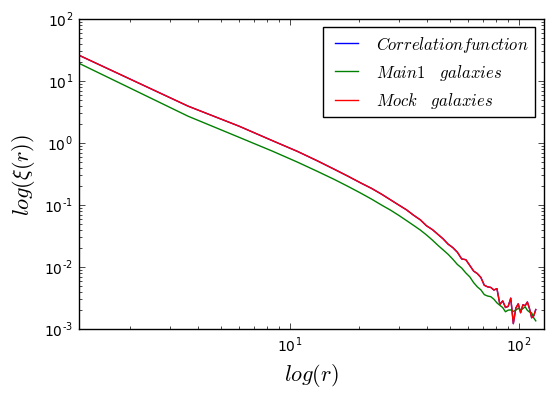

In [18]:
corr_func = np.loadtxt('/home/icgguest/Desktop/CUTE-1.3/CUTE_box/test/CF_Main1_gals.txt')
corr_func = corr_func[:,0:2]
plt.plot(corr_func[:,0], corr_func[:,1], label = r'$Main1 \quad galaxies$')
plt.plot(cf_mock[:,0], cf_mock[:,1], label = r'$Mock \quad galaxies$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(np.amin(corr_func[:,0]), np.amax(corr_func[:,0])+10)
plt.xlabel('$log(r)$', size ='16')
plt.ylabel(r'$log(\xi(r))$', size ='16')
plt.legend(loc=0)
plt.show()

Correlation function as a funtion of r with randoms

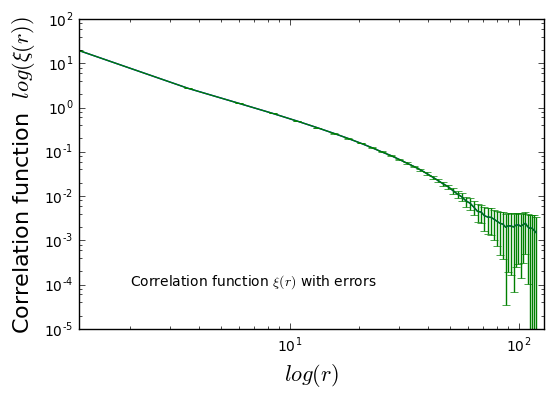

In [21]:
cf_random = np.loadtxt('/home/icgguest/Desktop/CUTE-1.3/CUTE_box/test/CF_random_Main1_gals.txt')
"monopole correlation neighbours with random"
cf_random = cf_random[:,0:3]
yerr = cf_random[:,2]
plt.plot(cf_random[:,0], cf_random[:,1])
plt.errorbar(cf_random[:,0], cf_random[:,1],yerr)
plt.xlim(np.amin(cf_random[:,0]), np.amax(cf_random[:,0])+10)
plt.xlabel('$log(r)$', size = '16')
plt.ylabel(r'Correlation function  $log(\xi(r))$', size = '16')
plt.xscale('log')
plt.yscale('log')
plt.annotate(r'Correlation function $\xi(r)$ with errors',xy = (2,10**(-4)))
plt.show()

#here random_data : 4000000
#retake data with updated random_data1

Make Mock galaxy data file to speed up testing the algorithm 

In [23]:
cf_sigmapi_mock = np.loadtxt('/home/icgguest/Desktop/DATA/MDR1_LOWZ_mockgals.txt')
mock_positions = cf_sigmapi_mock[:,1:4]
np.savetxt('/home/icgguest/Desktop/DATA/LOWZ_mockgals.txt', mock_positions)

In [37]:
Nparticls = 297842*50
random_data2 = boxLen*np.random.random((Nparticls,3))
np.savetxt('/home/icgguest/Desktop/DATA/random_data_mock', random_data2, fmt='%0.6f')

Correlation function as a funtion of sigma and pi

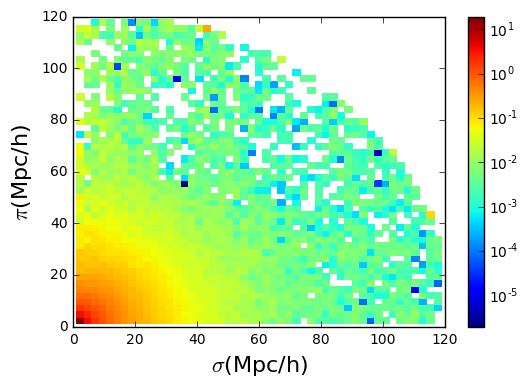

In [35]:
cf_sigmapi = np.loadtxt('/home/icgguest/Desktop/CUTE-1.3/CUTE_box/test/CFsigmapi_Mockgals.txt')
cf_sigmapi = cf_sigmapi[:,0:3]
xi_spi = cf_sigmapi[:,2].reshape((50,50))
x_spi = cf_sigmapi[::50,0]
y_spi = cf_sigmapi[:50,1]
plt.pcolormesh(x_spi ,y_spi ,xi_spi, norm= LogNorm())
plt.colorbar()
plt.xlabel('$\sigma$(Mpc/h)',  size ='16')
plt.ylabel(r'$\pi$(Mpc/h)',  size ='16')
plt.show()

Testing of the Correlation function by comparing auto-correlation and cross-correlation algorithms

In [25]:
cf_rmu_test= np.loadtxt('/home/icgguest/Desktop/CUTE-1.3/CUTE_box/test/CFrmu_Main1_gals_test.txt')
ccf_rmu_test= np.loadtxt('/home/icgguest/Desktop/CUTE-1.3/CUTE_box/test/CCFrmu_Main1_gals_test.txt')
xi_rmu_test = cf_rmu_test[:,4].reshape(50,60)
x_rmu_test = cf_rmu_test[::60,0]
y_rmu_test = cf_rmu_test[:60,1]
xi_rmu_test1 = ccf_rmu_test[:,4].reshape(50,60)
x_rmu_test1 = ccf_rmu_test[::60,0]
y_rmu_test1 = ccf_rmu_test[:60,1]

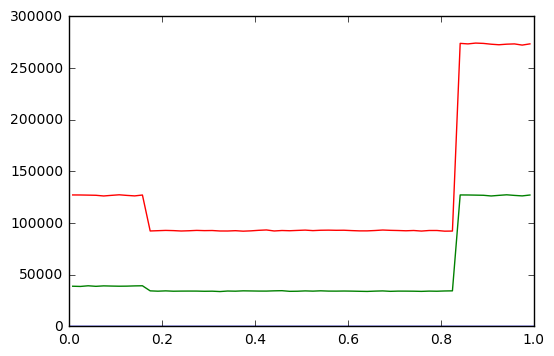

In [86]:
from scipy.interpolate import interp1d
ximu = interp1d(y_rmu,xi_rmu[0],fill_value='extrapolate')
mu = np.linspace(0,1)
plt.plot(mu,ximu(mu))
# plt.plot(y_rmu_test,xi_rmu_test[10]/xi_rmu_test1[10])
plt.plot(y_rmu_test,xi_rmu_test[1])
plt.plot(y_rmu_test,xi_rmu_test[2])
# plt.plot(y_rmu_test1, xi_rmu_test1[10])
# plt.plot(y_rmu_test1,xi_rmu_test1[1])
# plt.plot(y_rmu_test1,xi_rmu_test1[2])
plt.show()

Calculation of multipoles for the correlation function

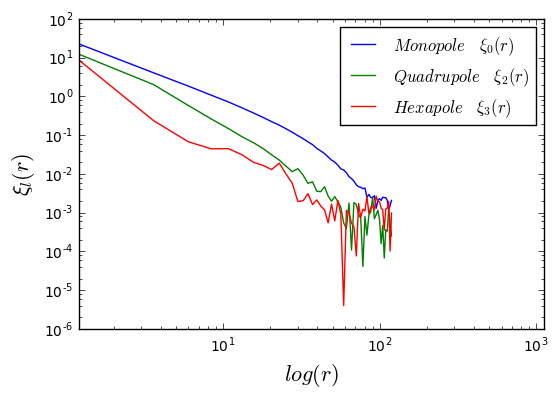

In [27]:
mono = xi_rmu*1
P = (1./2)*(3*(y_rmu**2) - 1)
quadr = xi_rmu*P
Q = (1./8)*(35*(y_rmu**4)-30*(y_rmu**2)+3)
hexa = xi_rmu*Q
monopole = np.trapz(mono, y_rmu)
quadrupole = 5* np.trapz(quadr, y_rmu)
hexapole = 7 * np.trapz(hexa, y_rmu)
plt.plot(x_rmu,monopole, label = r'$Monopole \quad \xi_{0}(r)$')
plt.plot(x_rmu, np.abs(quadrupole), label= r'$Quadrupole \quad \xi_{2}(r)$')
plt.plot(x_rmu, np.abs(hexapole), label= r'$Hexapole \quad \xi_{3}(r)$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(np.amin(cf_mock[:,0]), np.amax(cf_mock[:,0])+1000)
plt.xlabel(r'$log(r)$', size = 16)
plt.ylabel(r'$\xi_{l}(r)$', size = '16')
plt.legend(loc = 1)
plt.show()

Adding RSD to the LOS position(z-axis)

In [4]:
RSD_data = np.loadtxt('/home/icgguest/Desktop/DATA/MDR1_LOWZ_mockgals.txt')

In [22]:
c = 3*(10**5)
z = 0
Omegam = 0.27
Ho = 100.
Hz = Ho * (np.sqrt(Omegam *((1+z)**3) +1 - Omegam))
RSD_data[:,3:4] = RSD_data[:,3:4] +((RSD_data[:,6:7]/c)*(3000))
new_data = RSD_data[:,1:4]
new_data[new_data[:,2] > boxLen,2] -=boxLen
new_data[new_data[:,2] < 0,2] +=boxLen
np.savetxt('/home/icgguest/Desktop/DATA/RSD_mockgals.txt', new_data)

Correlation function in redshift space for r mu

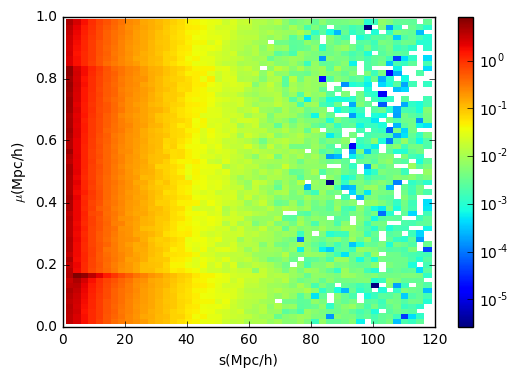

In [25]:
cf_rmu_RSD = np.loadtxt('/home/icgguest/Desktop/CUTE-1.3/CUTE_box/test/CFrmu_RSD_Mockgals.txt')
cf_rmu_RSD = cf_rmu_RSD[:,0:3]
xi_rmu_RSD = cf_rmu_RSD[:,2].reshape(50,60)
x_rmu_RSD = cf_rmu_RSD[::60,0]
y_rmu_RSD = cf_rmu_RSD[:60,1]
plt.pcolormesh(x_rmu_RSD, y_rmu_RSD, xi_rmu_RSD.transpose(), norm= LogNorm())
plt.colorbar()
plt.xlabel('s(Mpc/h)')
plt.ylabel(r'$\mu$(Mpc/h)')
plt.show()

Correlation function in redshift space for sigma pi

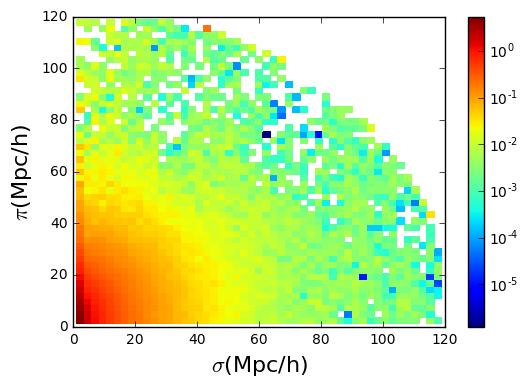

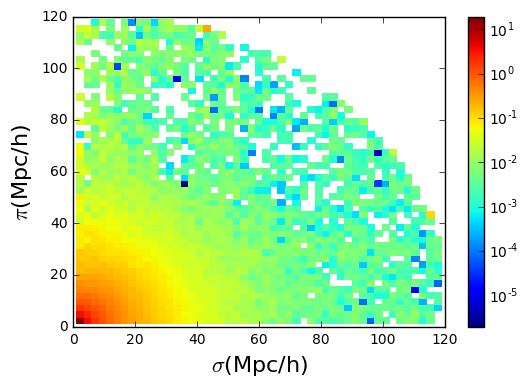

In [33]:
plt.figure(1)
cf_sigmapi_RSD = np.loadtxt('/home/icgguest/Desktop/CUTE-1.3/CUTE_box/test/CFsigmapi_RSD_Mockgals.txt')
cf_sigmapi_RSD = cf_sigmapi_RSD[:,0:3]
xi_spi_RSD = cf_sigmapi_RSD[:,2].reshape((50,50))
x_spi_RSD = cf_sigmapi_RSD[::50,0]
y_spi_RSD = cf_sigmapi_RSD[:50,1]
plt.pcolormesh(x_spi_RSD ,y_spi_RSD ,xi_spi_RSD, norm= LogNorm())
plt.colorbar()
plt.xlabel('$\sigma$(Mpc/h)',  size ='16')
plt.ylabel(r'$\pi$(Mpc/h)',  size ='16')
plt.figure(2)
cf_sigmapi = np.loadtxt('/home/icgguest/Desktop/CUTE-1.3/CUTE_box/test/CFsigmapi_Mockgals.txt')
cf_sigmapi = cf_sigmapi[:,0:3]
xi_spi = cf_sigmapi[:,2].reshape((50,50))
x_spi = cf_sigmapi[::50,0]
y_spi = cf_sigmapi[:50,1]
plt.pcolormesh(x_spi ,y_spi ,xi_spi, norm= LogNorm())
plt.colorbar()
plt.xlabel('$\sigma$(Mpc/h)', size = '16')
plt.ylabel(r'$\pi$(Mpc/h)', size ='16')
plt.show()

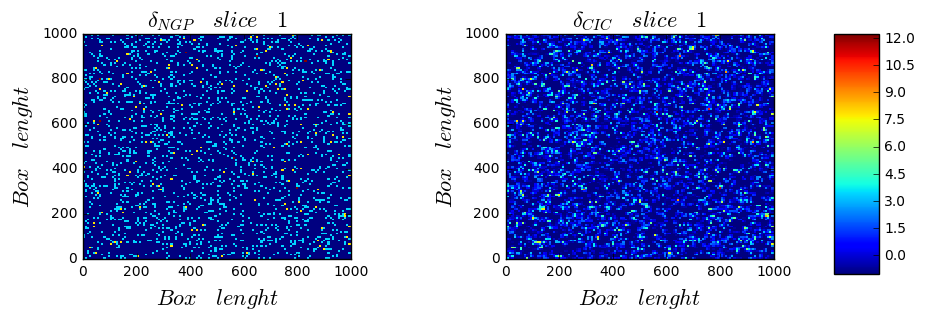

In [34]:
plt.subplot(221)
plt.pcolormesh(np.linspace(0, boxLen, Ngrid+1),np.linspace(0, boxLen, Ngrid+1), deltaNGP[0, :, :])
plt.title(r'$\delta_{NGP} \quad slice \quad 1$', size = '16')
plt.xlabel(r'$Box \quad lenght$', size = '16')
plt.ylabel(r'$Box \quad lenght$', size = '16')
plt.subplot(222)
plt.pcolormesh(np.linspace(0, boxLen, Ngrid+1),np.linspace(0, boxLen, Ngrid+1), deltaCIC[0, :, :])
plt.title(r'$\delta_{CIC} \quad slice \quad 1$', size = '16')
plt.xlabel(r'$Box \quad lenght$', size = '16')
plt.ylabel(r'$Box \quad lenght$', size = '16')
plt.tight_layout()
plt.subplots_adjust(bottom= 0.1, right=1.3, top=1.5)
cax = plt.axes([1.4, 0.9, 0.075, 0.6])
plt.colorbar(cax=cax)
plt.show()

Overdensity plot for galaxy data using NGP method

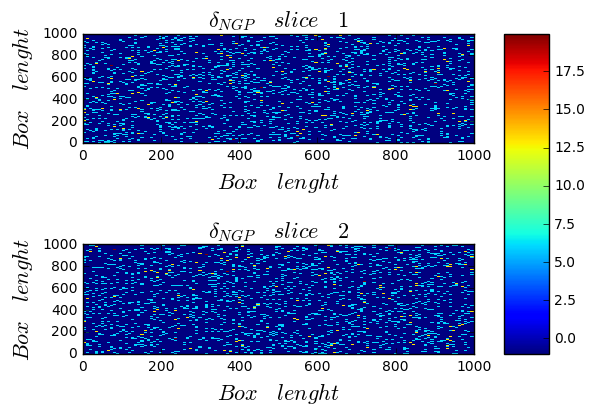

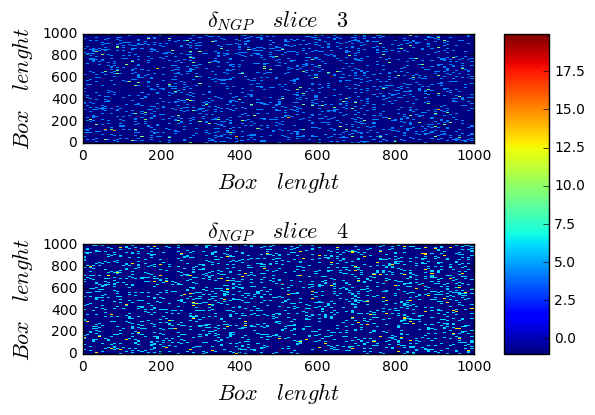

In [18]:
plt.subplot(211)
plt.pcolormesh(np.linspace(0, boxLen, Ngrid+1),np.linspace(0, boxLen, Ngrid+1), deltaNGP[0, :, :])
plt.title(r'$\delta_{NGP} \quad slice \quad 1$', size = '16')
plt.xlabel(r'$Box \quad lenght$', size = '16')
plt.ylabel(r'$Box \quad lenght$', size = '16')
plt.tight_layout()
plt.subplot(212)
plt.pcolormesh(np.linspace(0, boxLen, Ngrid+1),np.linspace(0, boxLen, Ngrid+1), deltaNGP[1, :, :])
plt.title(r'$\delta_{NGP} \quad slice \quad 2$', size = '16')
plt.xlabel(r'$Box \quad lenght$', size = '16')
plt.ylabel(r'$Box \quad lenght$', size = '16')
plt.tight_layout()
plt.subplots_adjust(bottom= 0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()
plt.subplot(211)
plt.pcolormesh(np.linspace(0, boxLen, Ngrid+1), np.linspace(0, boxLen, Ngrid+1), deltaNGP[2, :, :])
plt.title(r'$\delta_{NGP} \quad slice \quad 3$', size = '16')
plt.xlabel(r'$Box \quad lenght$', size = '16')
plt.ylabel(r'$Box \quad lenght$', size = '16')
plt.tight_layout()
plt.subplot(212)
plt.pcolormesh(np.linspace(0, boxLen, Ngrid+1), np.linspace(0, boxLen, Ngrid+1), deltaNGP[3, :, :])
plt.title(r'$\delta_{NGP} \quad slice \quad 4$', size = '16')
plt.xlabel(r'$Box \quad lenght$', size = '16')
plt.ylabel(r'$Box \quad lenght$', size = '16')
plt.tight_layout()
plt.subplots_adjust(bottom= 0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

Overdensity plot for galaxy data using CIC method

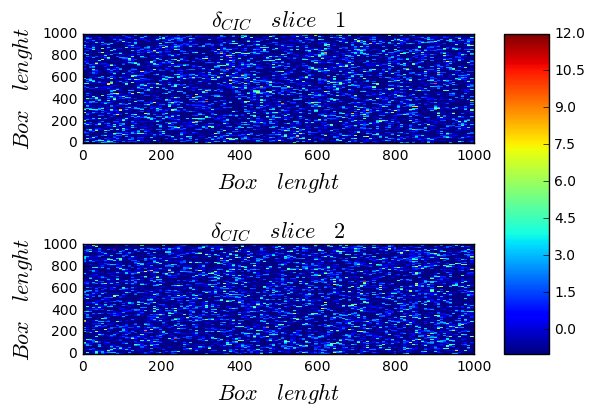

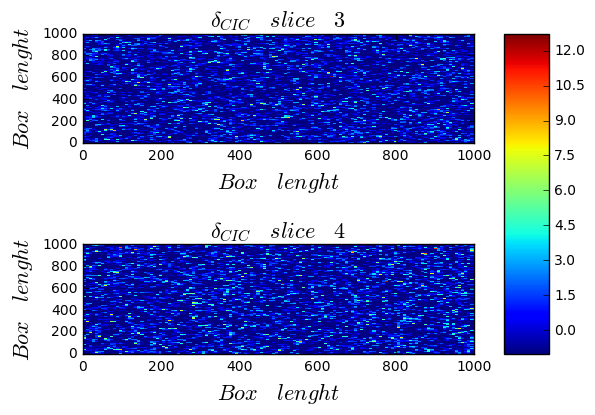

In [19]:
# plt.subplot(221)
# plt.pcolormesh(np.linspace(0, boxLen, Ngrid+1), np.linspace(0, boxLen, Ngrid+1), deltaCIC[0, :, :])
# plt.colorbar()
# plt.subplot(222)
# plt.pcolormesh(np.linspace(0, boxLen, Ngrid+1), np.linspace(0, boxLen, Ngrid+1), deltaCIC[1, :, :])
# plt.colorbar()
# plt.subplot(223)
# plt.pcolormesh(np.linspace(0, boxLen, Ngrid+1), np.linspace(0, boxLen, Ngrid+1), deltaCIC[2, :, :])
# plt.colorbar()
# plt.subplot(224)
# plt.pcolormesh(np.linspace(0, boxLen, Ngrid+1), np.linspace(0, boxLen, Ngrid+1), deltaCIC[3, :, :])
# plt.colorbar()
# plt.show()

plt.subplot(211)
plt.pcolormesh(np.linspace(0, boxLen, Ngrid+1),np.linspace(0, boxLen, Ngrid+1), deltaCIC[0, :, :])
plt.title(r'$\delta_{CIC} \quad slice \quad 1$', size = '16')
plt.xlabel(r'$Box \quad lenght$', size = '16')
plt.ylabel(r'$Box \quad lenght$', size = '16')
plt.tight_layout()
plt.subplot(212)
plt.pcolormesh(np.linspace(0, boxLen, Ngrid+1),np.linspace(0, boxLen, Ngrid+1), deltaCIC[1, :, :])
plt.title(r'$\delta_{CIC} \quad slice \quad 2$', size = '16')
plt.xlabel(r'$Box \quad lenght$', size = '16')
plt.ylabel(r'$Box \quad lenght$', size = '16')
plt.tight_layout()
plt.subplots_adjust(bottom= 0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()
plt.subplot(211)
plt.pcolormesh(np.linspace(0, boxLen, Ngrid+1), np.linspace(0, boxLen, Ngrid+1), deltaCIC[2, :, :])
plt.title(r'$\delta_{CIC} \quad slice \quad 3$', size = '16')
plt.xlabel(r'$Box \quad lenght$', size = '16')
plt.ylabel(r'$Box \quad lenght$', size = '16')
plt.tight_layout()
plt.subplot(212)
plt.pcolormesh(np.linspace(0, boxLen, Ngrid+1), np.linspace(0, boxLen, Ngrid+1), deltaCIC[3, :, :])
plt.title(r'$\delta_{CIC} \quad slice \quad 4$', size = '16')
plt.xlabel(r'$Box \quad lenght$', size = '16')
plt.ylabel(r'$Box \quad lenght$', size = '16')
plt.tight_layout()
plt.subplots_adjust(bottom= 0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()
